## SET-UP SAMPLE & NOTEBOOK

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load modules
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import seqc
import pickle
import re
from collections import defaultdict, OrderedDict
from imp import reload
from itertools import combinations

In [3]:
# NOTEBOOK SET-UP

SAMPLE_NAME = 'EXAMPLE'

# directory information
IN_DATA_DIR = os.path.expanduser('A/DIRECTORY')
DATA_DIR = os.path.expanduser('SOMEWHERE/ELSE')
FIGURE_DIR = os.path.expanduser('A/THIRD/PLACE')

# read/molecule count files
INPUT_FILES = [
    'f1',
    'f2',
    'f3',
    'f4',
    'f5',
    'f6',
    'f7',
    'f8',
    'f9',
    'f10'
]
INPUT_ALIASES = [
    'KJ_DJ009',
    'KJ_MSKCC',
    'KJ_MP',
    'CL_MSKCC',
    'CL_MP',
    'CL_DJ010',
    'BO_DJ020',
    'BO_DJ021',
    'BO_DJ022',
    'CD_DJ023'
]
GTF_LOCATION = '{}annotations.gtf'.format(IN_DATA_DIR)  # annotations.gtf

ORGANISM = 'human'  # human or mouse

In [4]:
# set plotting defaults
sns.set_style('ticks')
matplotlib.rc('font', **{'serif': ['Computer Modern Roman'],
                         'monospace': ['Computer Modern Typewriter']
                         })

matplotlib.rc('figure', **{'figsize': (4, 4),
                           'dpi': 150})

matplotlib.rc('patch', **{'facecolor': 'royalblue',
                          'edgecolor': 'none'})

matplotlib.rc('lines', **{'color': 'royalblue',
                          'markersize': 7})

matplotlib.rc('savefig', **{'dpi': '150'})
cmap = matplotlib.cm.viridis
size = 8

In [5]:
os.makedirs(FIGURE_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

## LOAD DATA

In [6]:
# get symbol converter
gene_id_map = seqc.core.Experiment.create_gene_id_to_official_gene_symbol_map(GTF_LOCATION)

# load data, convert to symbols
experiments = OrderedDict(
    (a, seqc.core.Experiment.from_count_matrices(IN_DATA_DIR + f))
    for a, f in zip(INPUT_ALIASES, INPUT_FILES))
for k, v in experiments.items():
    experiments[k] = v.ensembl_gene_id_to_official_gene_symbol(gene_id_map=gene_id_map)

## PLOT COVERAGE, FILTER NON-CELLS

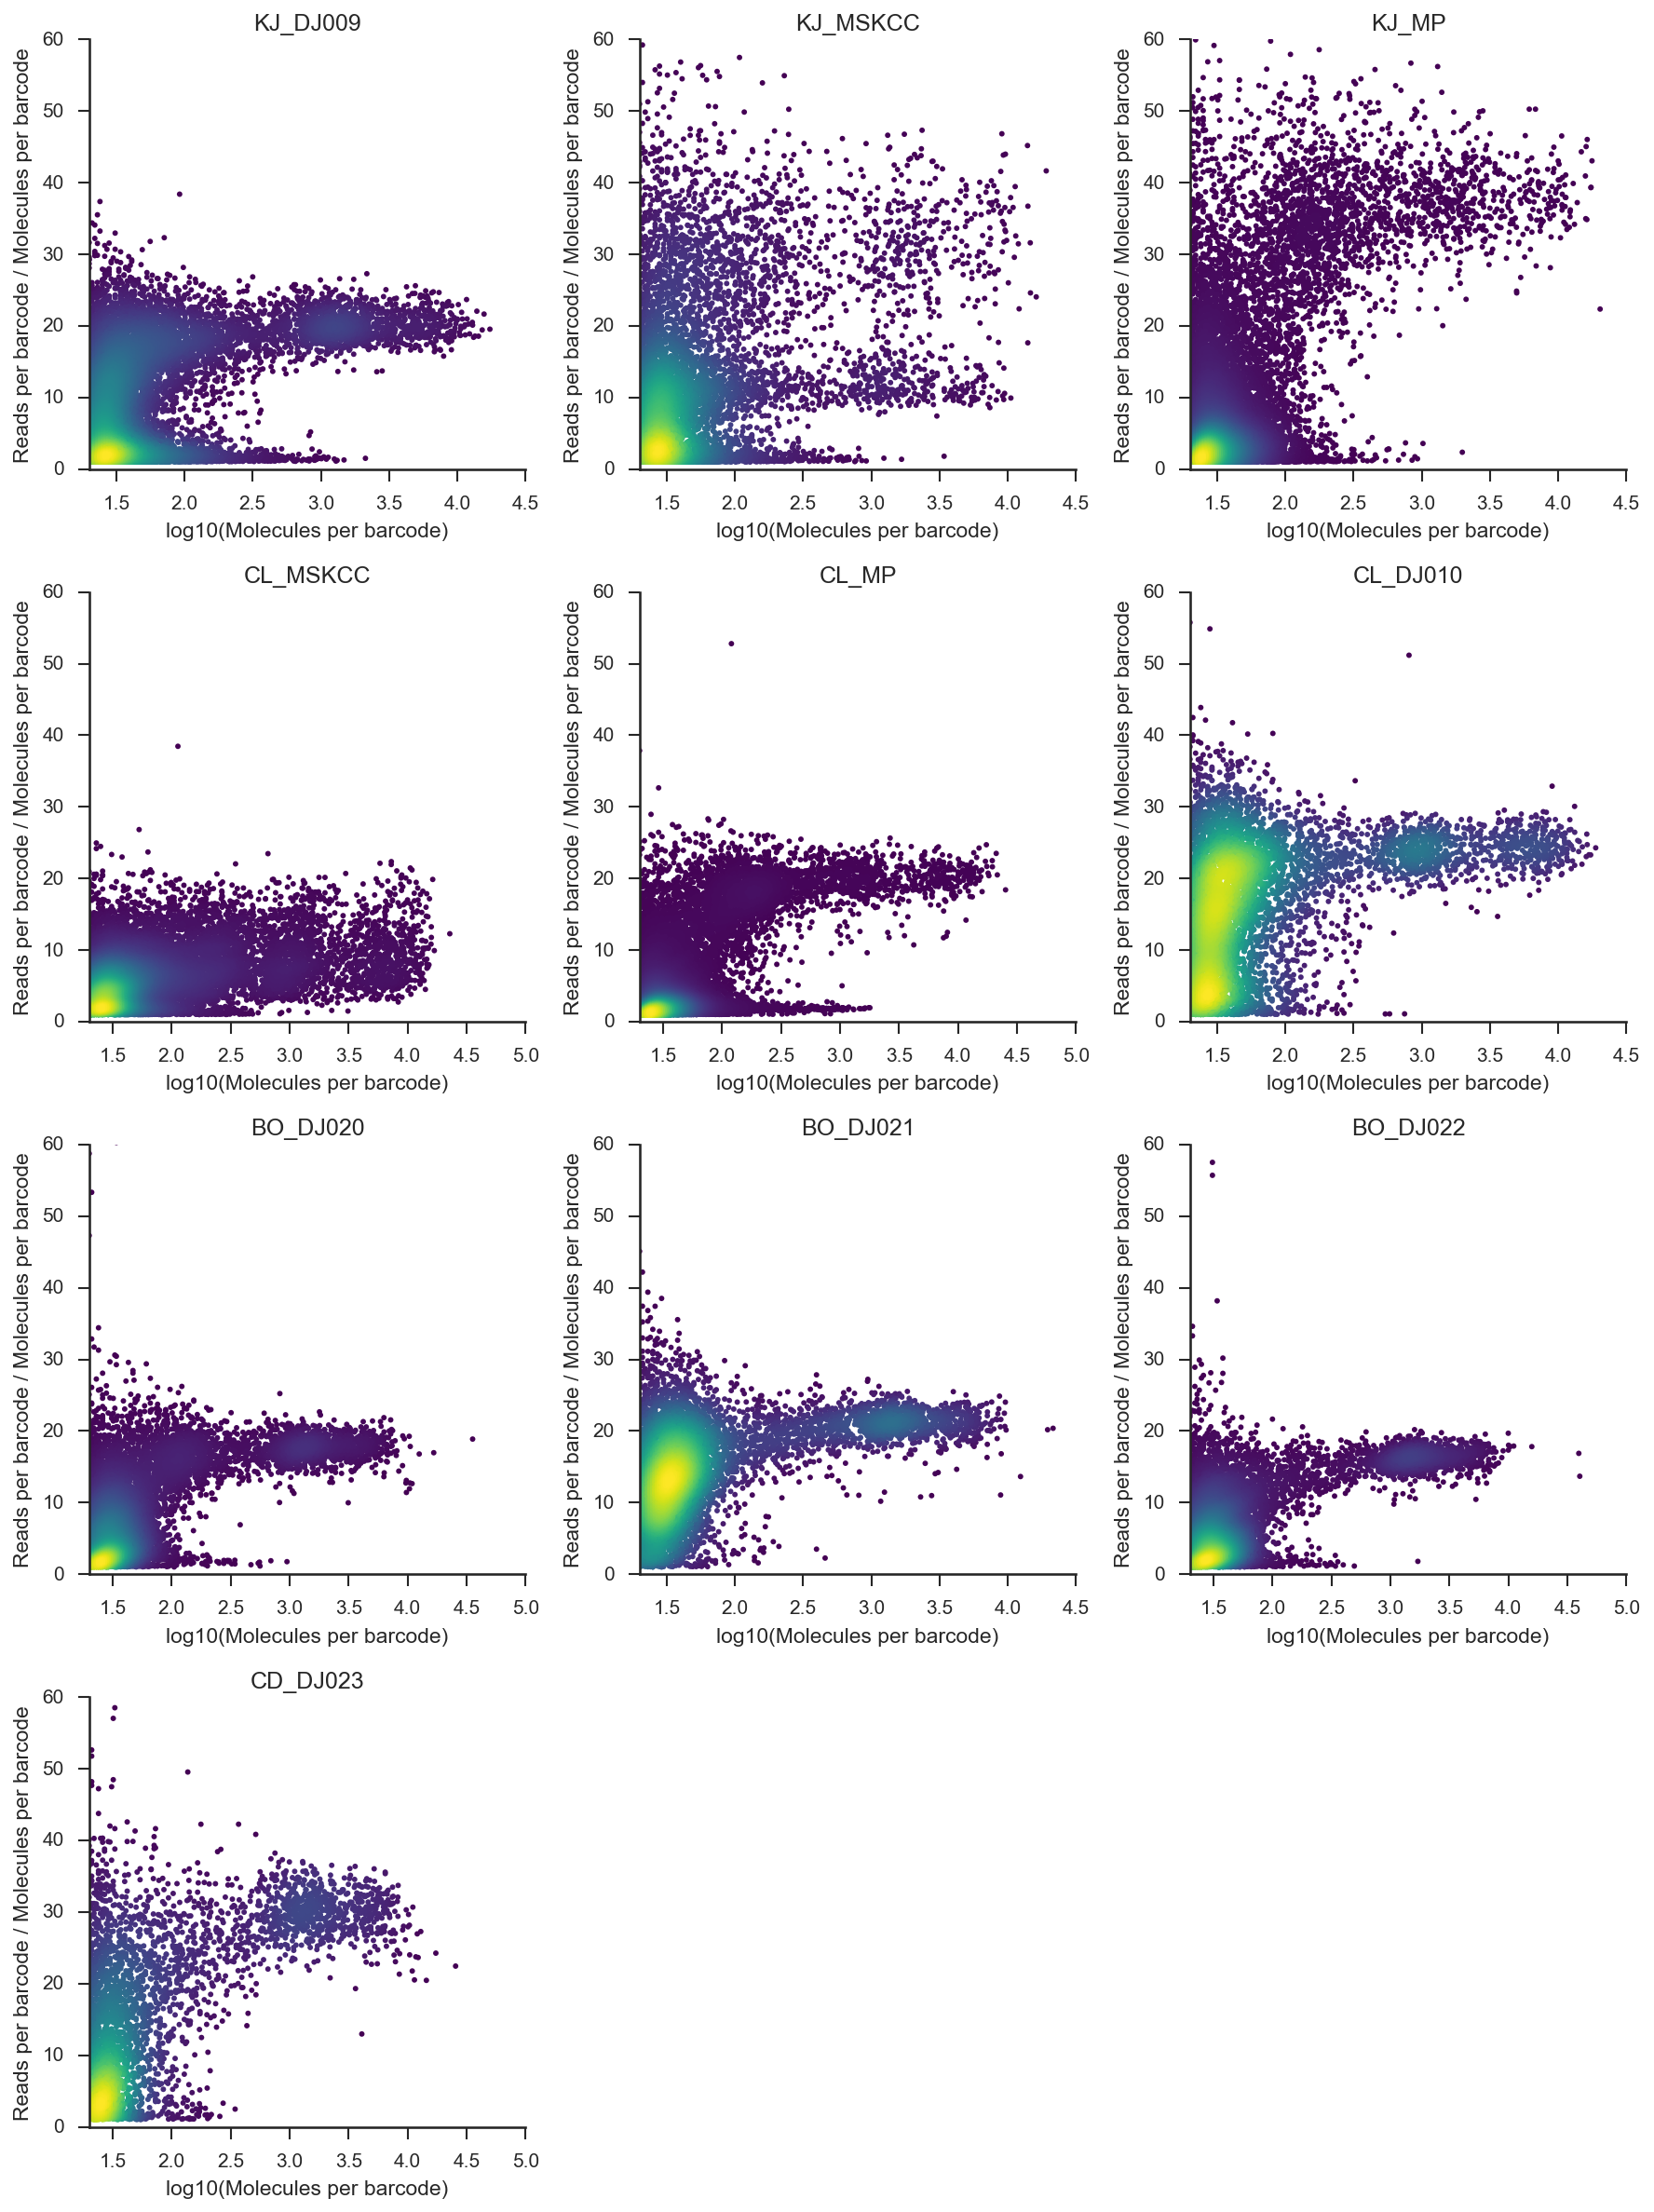

In [7]:
# plot cells vs. average coverage
# set up plot
fig = seqc.core.FigureGrid(len(experiments))

for (k, v), ax in zip(experiments.items(), fig):
    v.plot_molecules_vs_reads_per_molecule(ylim=(0, 60), title=k, fig=fig, ax=ax,
                                           min_molecules=20)
fig.despine()
fig.tight_layout()
fig.savefig(FIGURE_DIR + SAMPLE_NAME + '_cell_rpm_ratio_plot.png', dpi=200)

In [8]:
# remove low coverage cells
COVERAGE_THRESHOLDS = [13, 8, 25, 6, 15, 18, 13, 15, 12, 22] # minimum average coverage
MPC=250  # minimum number of molecules per cell
dense_experiments = {k: v.remove_non_cell_barcodes(min_rpm=t, min_mpc=MPC)
                     for t, (k, v) in zip(COVERAGE_THRESHOLDS, experiments.items())}

## PLOT MT-FRACTION, FILTER DEAD CELLS

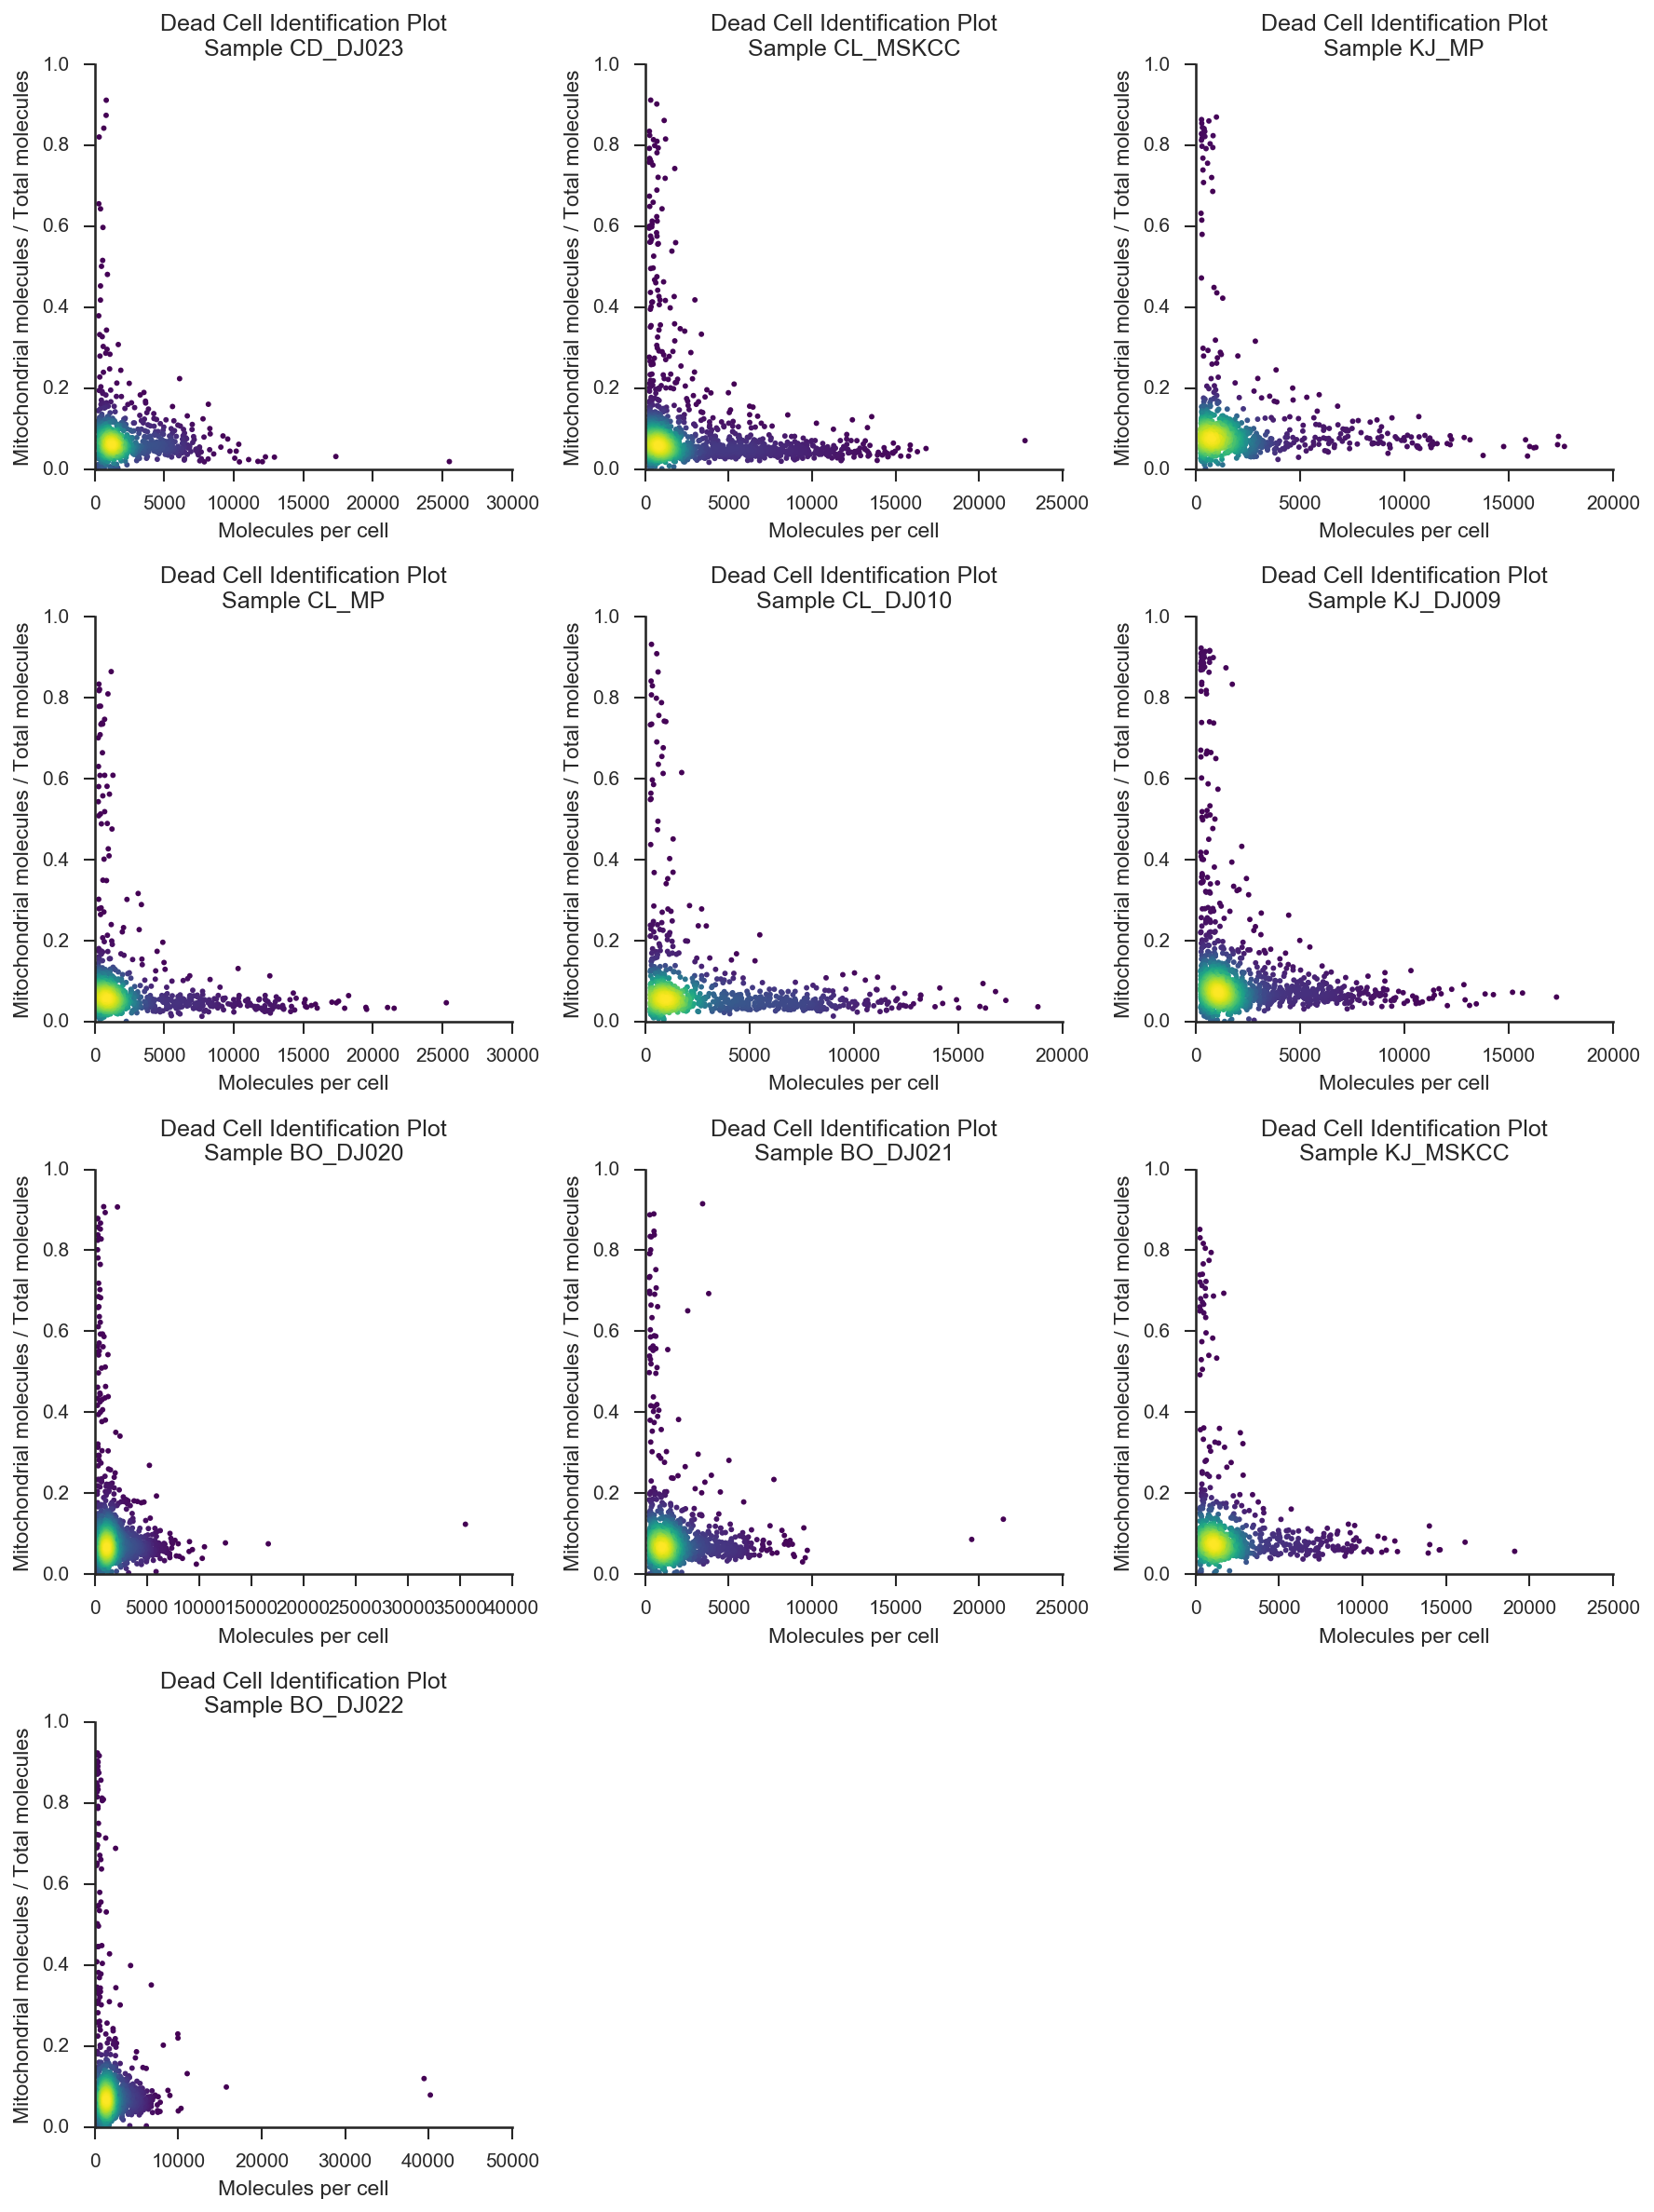

In [9]:
# plot mitochondrial content
fig = seqc.core.FigureGrid(len(dense_experiments))
for (k, v), ax in zip(dense_experiments.items(), fig):
    v.plot_mitochondrial_molecule_fraction(
        title='Dead Cell Identification Plot\nSample {}'.format(k), fig=fig, ax=ax)
fig.tight_layout()
fig.savefig(FIGURE_DIR + SAMPLE_NAME + '_dead_cell_mt_plot.png', dpi=200)

In [10]:
# remove dead cells
# heuristic, change if density of real cells in bottom of plot is not bounded by ~ y=0.18
MAXIMUM_MT_FRACTION = 0.18
for k, v in dense_experiments.items():
    dense_experiments[k] = v.exclude_dead_cells_with_high_mt_fraction(MAXIMUM_MT_FRACTION)

## PLOT MOLECULES VS. GENES (LOOK FOR LOW COMPLEXITY CELLS)

/usr/local/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


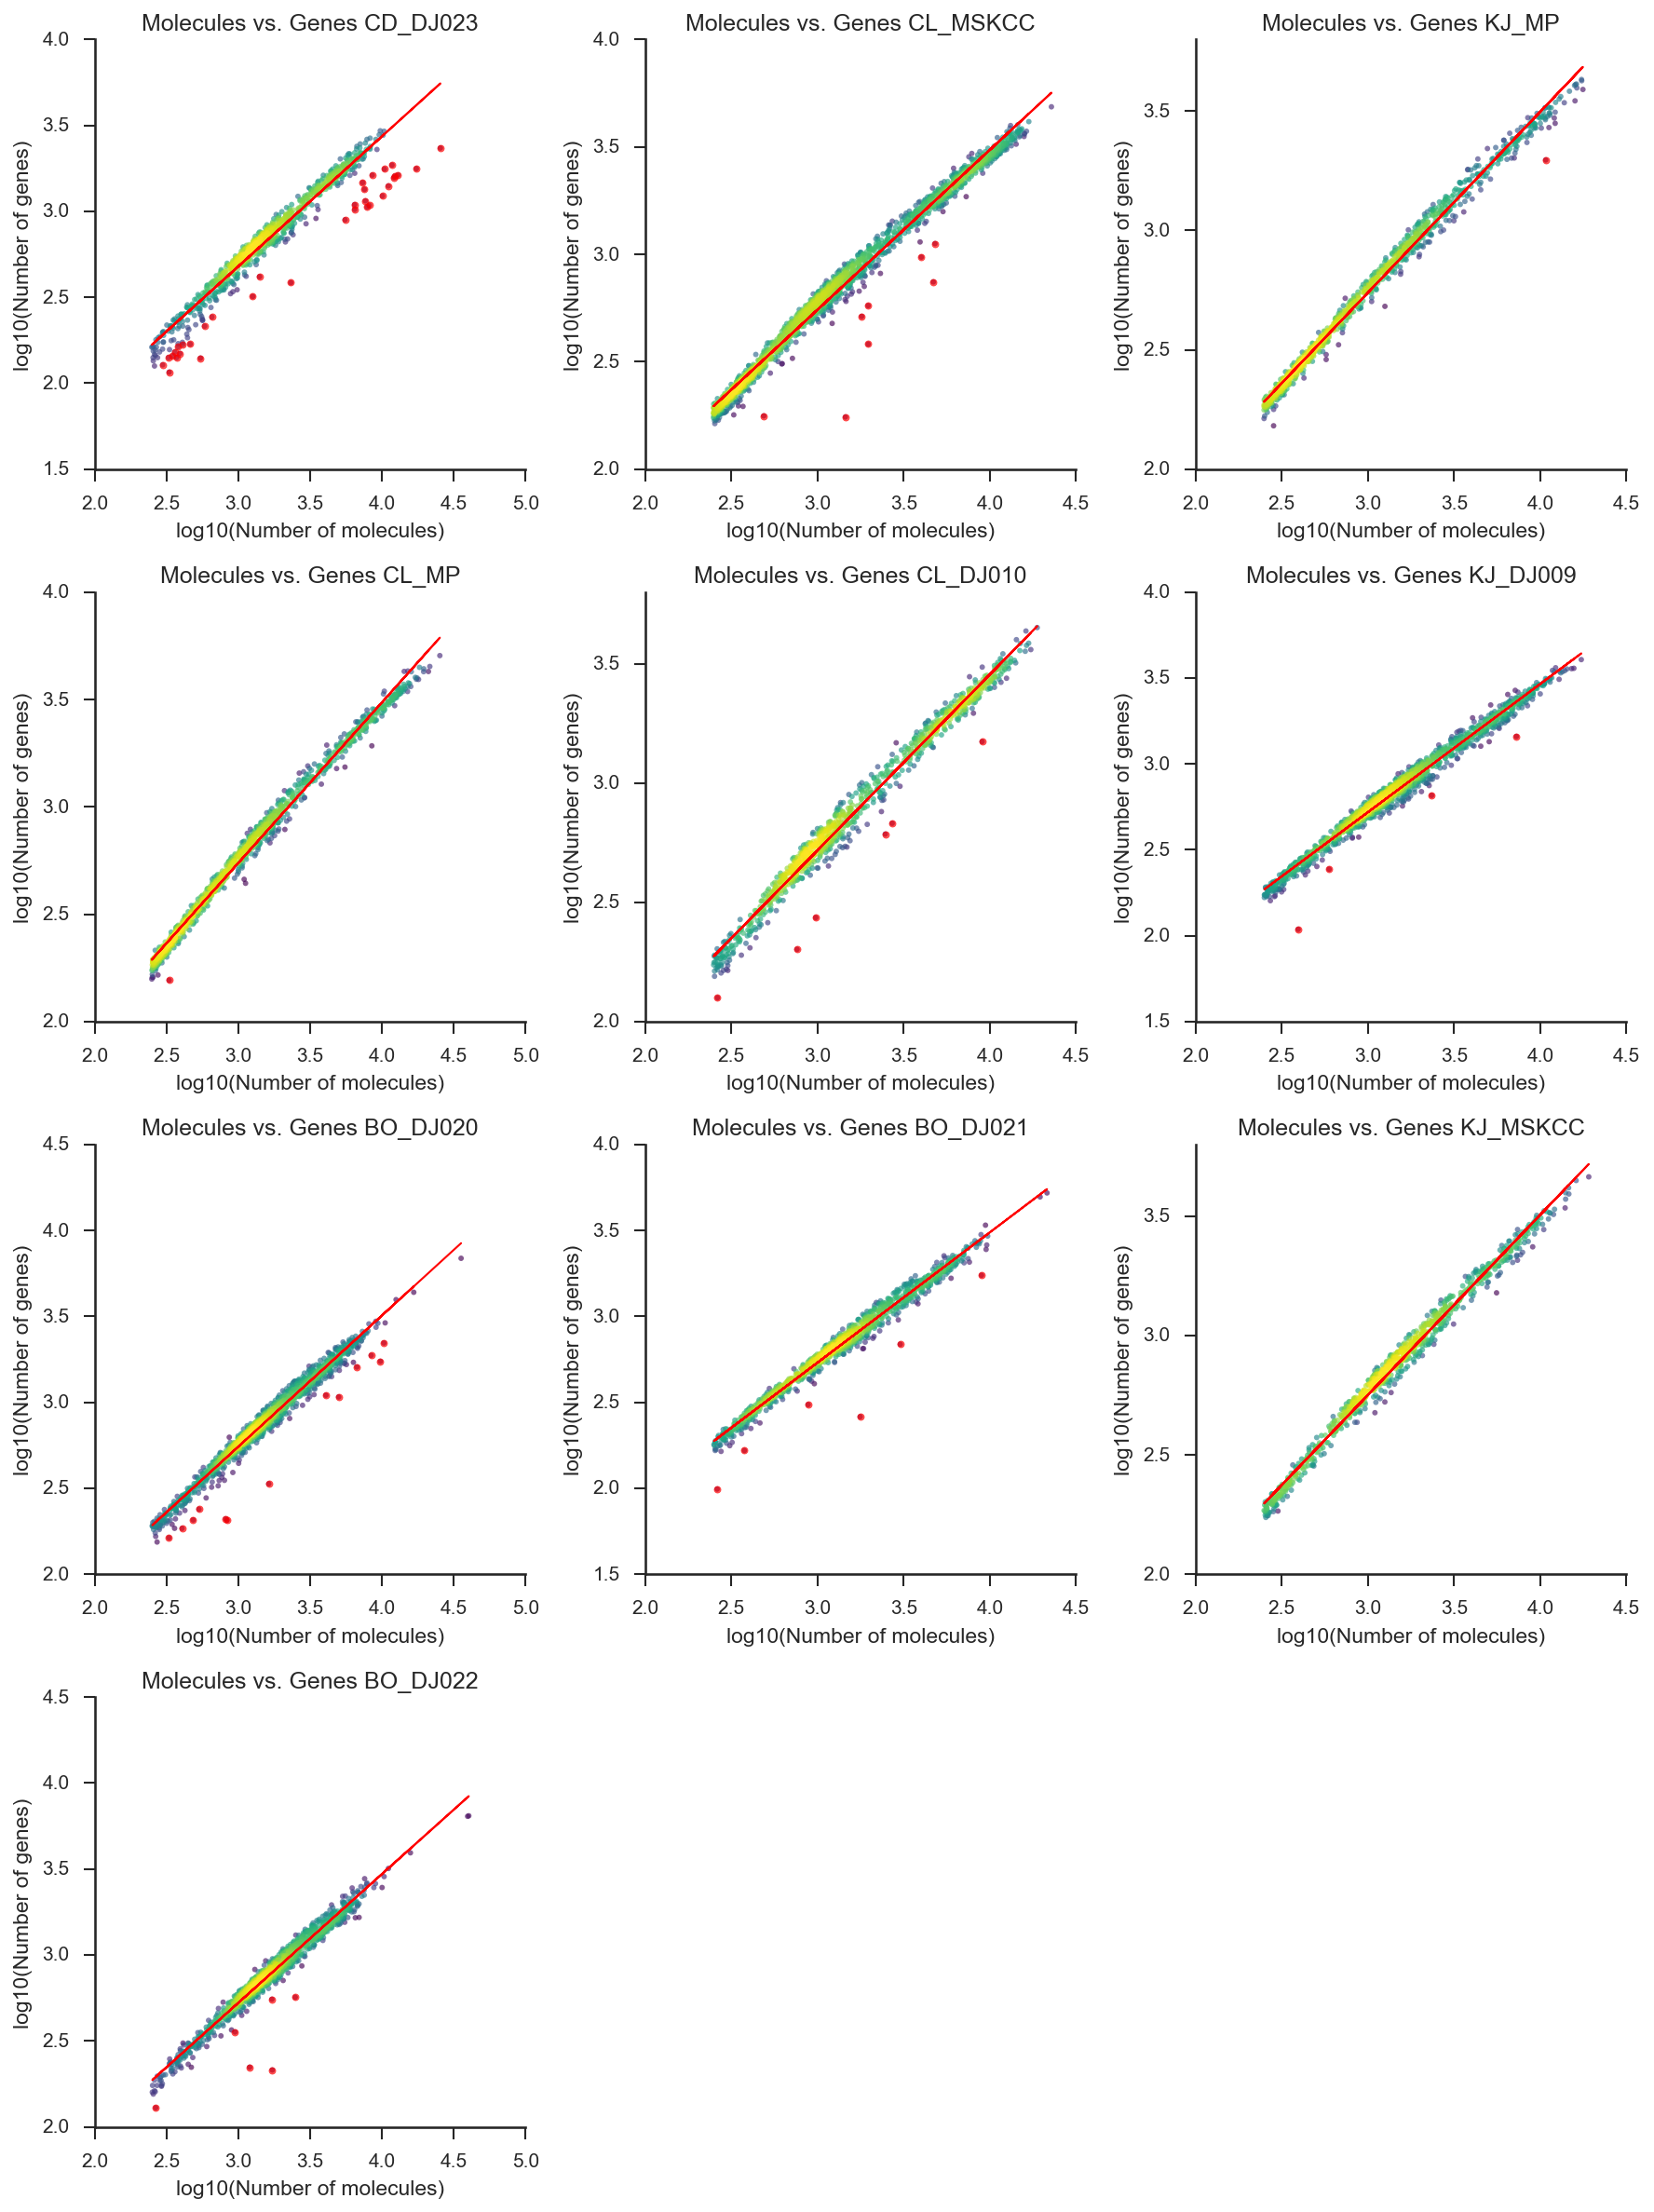

In [11]:
fig = seqc.core.FigureGrid(len(dense_experiments))
for (k, v), ax in zip(dense_experiments.items(), fig):
    v.plot_molecules_vs_genes(fig=fig, ax=ax, title='Molecules vs. Genes {}'.format(k))
fig.tight_layout()
fig.savefig(FIGURE_DIR + SAMPLE_NAME + '_genes_vs_molecules.png', dpi=200)

In [12]:
# remove low-complexity cells
for v in dense_experiments.values():
    v.remove_low_complexity_cells()

In [13]:
# print summary of summary statistics for each experiment
for k, v in dense_experiments.items():
    cellsums = v.molecules.sum(axis=1)
    print('sample: {}'.format(k))
    print('mean molecules per cell: {}'.format(np.mean(cellsums)))
    print('median molecules per cell: {}'.format(np.median(cellsums)))
    print('number of cells: {}\n'.format(len(cellsums)))

sample: CD_DJ023
mean molecules per cell: 2255.93391521197
median molecules per cell: 1522.5
number of cells: 802

sample: CL_MSKCC
mean molecules per cell: 2751.9817376867736
median molecules per cell: 1108.0
number of cells: 1807

sample: KJ_MP
mean molecules per cell: 2143.521064301552
median molecules per cell: 984.5
number of cells: 902

sample: CL_MP
mean molecules per cell: 2718.7182962245884
median molecules per cell: 1112.0
number of cells: 1033

sample: CL_DJ010
mean molecules per cell: 3164.6298283261804
median molecules per cell: 1354.5
number of cells: 932

sample: KJ_DJ009
mean molecules per cell: 2358.9164926931107
median molecules per cell: 1394.0
number of cells: 1437

sample: BO_DJ020
mean molecules per cell: 2019.8362934362935
median molecules per cell: 1411.0
number of cells: 1295

sample: BO_DJ021
mean molecules per cell: 1977.771040723982
median molecules per cell: 1363.0
number of cells: 1105

sample: KJ_MSKCC
mean molecules per cell: 2425.70802919708
median mole

## RUN FIRST ROUND OF GENE SELECTION

In [14]:
if len(experiments) != 1:
    experiment = seqc.core.Experiment.concatenate(
        list(dense_experiments.values()),
        metadata_labels={'experiment': tuple(dense_experiments.keys())})
else:
    experiment = next(iter(dense_experiments.values()))

In [15]:
# delete unmerged experiments to free memory
import gc
del dense_experiments
del experiments
gc.collect()

35545

In [16]:
# save unnormalized experiment to pickle, text
# experiment.save(DATA_DIR + SAMPLE_NAME + '_unnormed_merged.p')
# experiment.molecules[experiment.molecules == 0] = np.nan
# experiment.molecules.to_csv(DATA_DIR + SAMPLE_NAME + '_unnormed_merged.csv')
# experiment.molecules = experiment.molecules.fillna(0)

In [17]:
# normalize
library_sizes = experiment.molecules.sum(axis=1)  # save these to plot lib-size effects later
experiment = experiment.normalize_data()

In [18]:
# remove housekeeping genes
experiment = experiment.remove_housekeeping_genes(organism=ORGANISM)

In [19]:
# run PCA
experiment.run_pca()

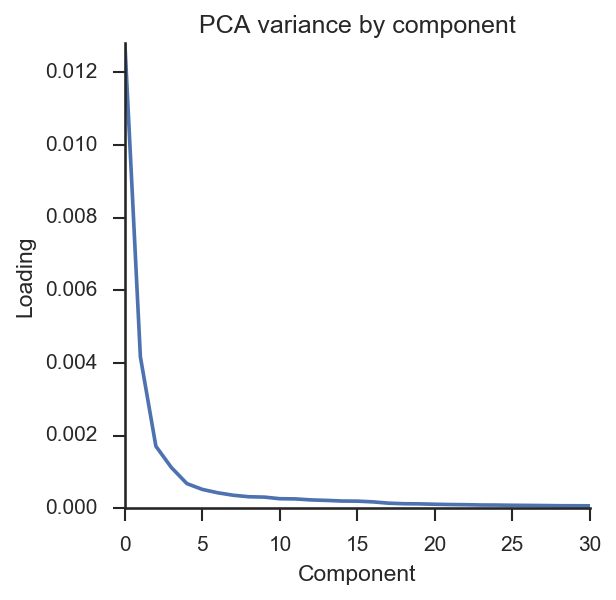

In [20]:
# plot variance explained, use elbow to select the number of components (normally ~10)
fig, ax = plt.subplots(figsize=(4, 4))
experiment.plot_pca_variance_explained(fig=fig, ax=ax)
fig.savefig(FIGURE_DIR + SAMPLE_NAME + '_pca_variance_explained_r1.png', dpi=200)

In [21]:
# select number of PCA components to keep based on the above plot (look for elbow)
N_PCA_COMPONENTS = 9

In [22]:
# run tSNE
experiment.run_tsne(n_components=N_PCA_COMPONENTS)

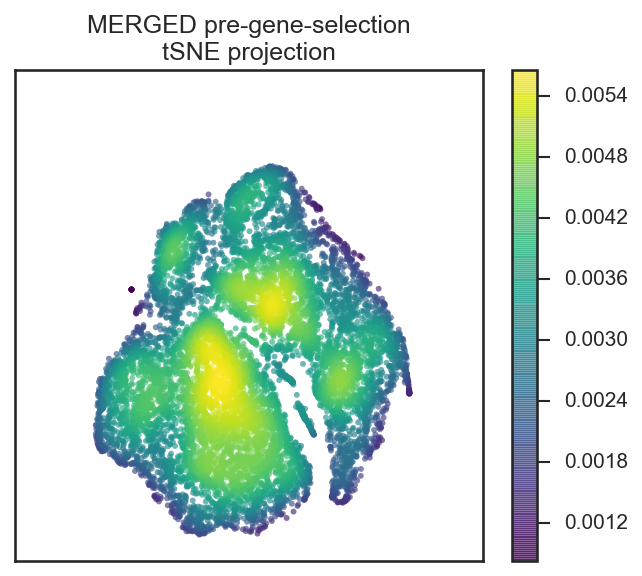

In [23]:
f, ax = plt.subplots(figsize=(4.5, 4))
f, ax = experiment.plot_tsne(
    title='{} pre-gene-selection\ntSNE projection'.format(SAMPLE_NAME))
f.tight_layout()
plt.savefig(FIGURE_DIR + SAMPLE_NAME + '_pre_gene_selection_tsne.png', dpi=200)

In [24]:
EXP_LABEL = 'experiment'  # name of label for metadata column
all_replicates = sorted(set(experiment.metadata[EXP_LABEL]))

## PLOT CLUSTERS BY TUMOR

In [25]:
EXPERIMENT_IDS = [0, 0, 0, 1, 2, 2, 2, 3, 3, 3]
n_experiments = set(EXPERIMENT_IDS)
# colors = seqc.core.qualitative_colors(N_EXPERIMENTS)
# color_map = {r: colors[i] for (i, r) zip(EXPERIMENT_IDS, all_replicates)}
valmap = {rname: v for (v, rname) in zip(EXPERIMENT_IDS, all_replicates)}
color_vector = np.array([valmap[r] for r in experiment.metadata[EXP_LABEL]])

(<matplotlib.figure.Figure at 0x138a67be0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x138a67438>)

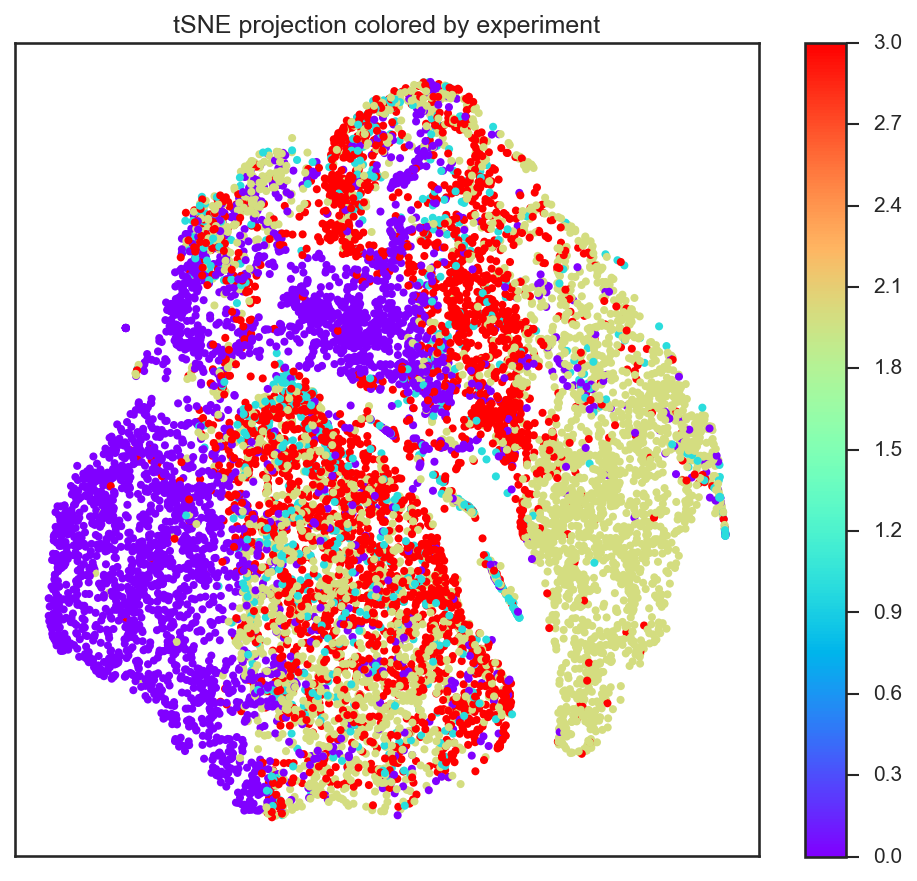

In [26]:
fig, ax = plt.subplots(figsize=(8, 7))
def plot_experiment(experiment, label):
    n = experiment.tsne.shape[0]
    rind = np.arange(n)
    np.random.shuffle(rind)
    sm = plt.scatter(experiment.tsne.iloc[rind, 0], experiment.tsne.iloc[rind, 1], s=15, c=color_vector[rind],
                     cmap=matplotlib.cm.rainbow, alpha=1)
    xmin = np.min(experiment.tsne['x'])
    xmax = np.max(experiment.tsne['x'])
    ax.set_xlim((xmin - 1, xmax + 1))
    ymin = np.min(experiment.tsne['y'])
    ymax = np.max(experiment.tsne['y'])
    ax.set_ylim((ymin - 1, ymax + 1))
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.set_title('tSNE projection colored by {}'.format(EXP_LABEL))
    plt.colorbar(sm)
    return fig, ax
    
_ = plot_experiment(experiment, 'experiment')

In [27]:
# run diffusion maps
experiment.run_diffusion_map(n_pca_components=N_PCA_COMPONENTS, n_diffusion_components=20, knn=60)

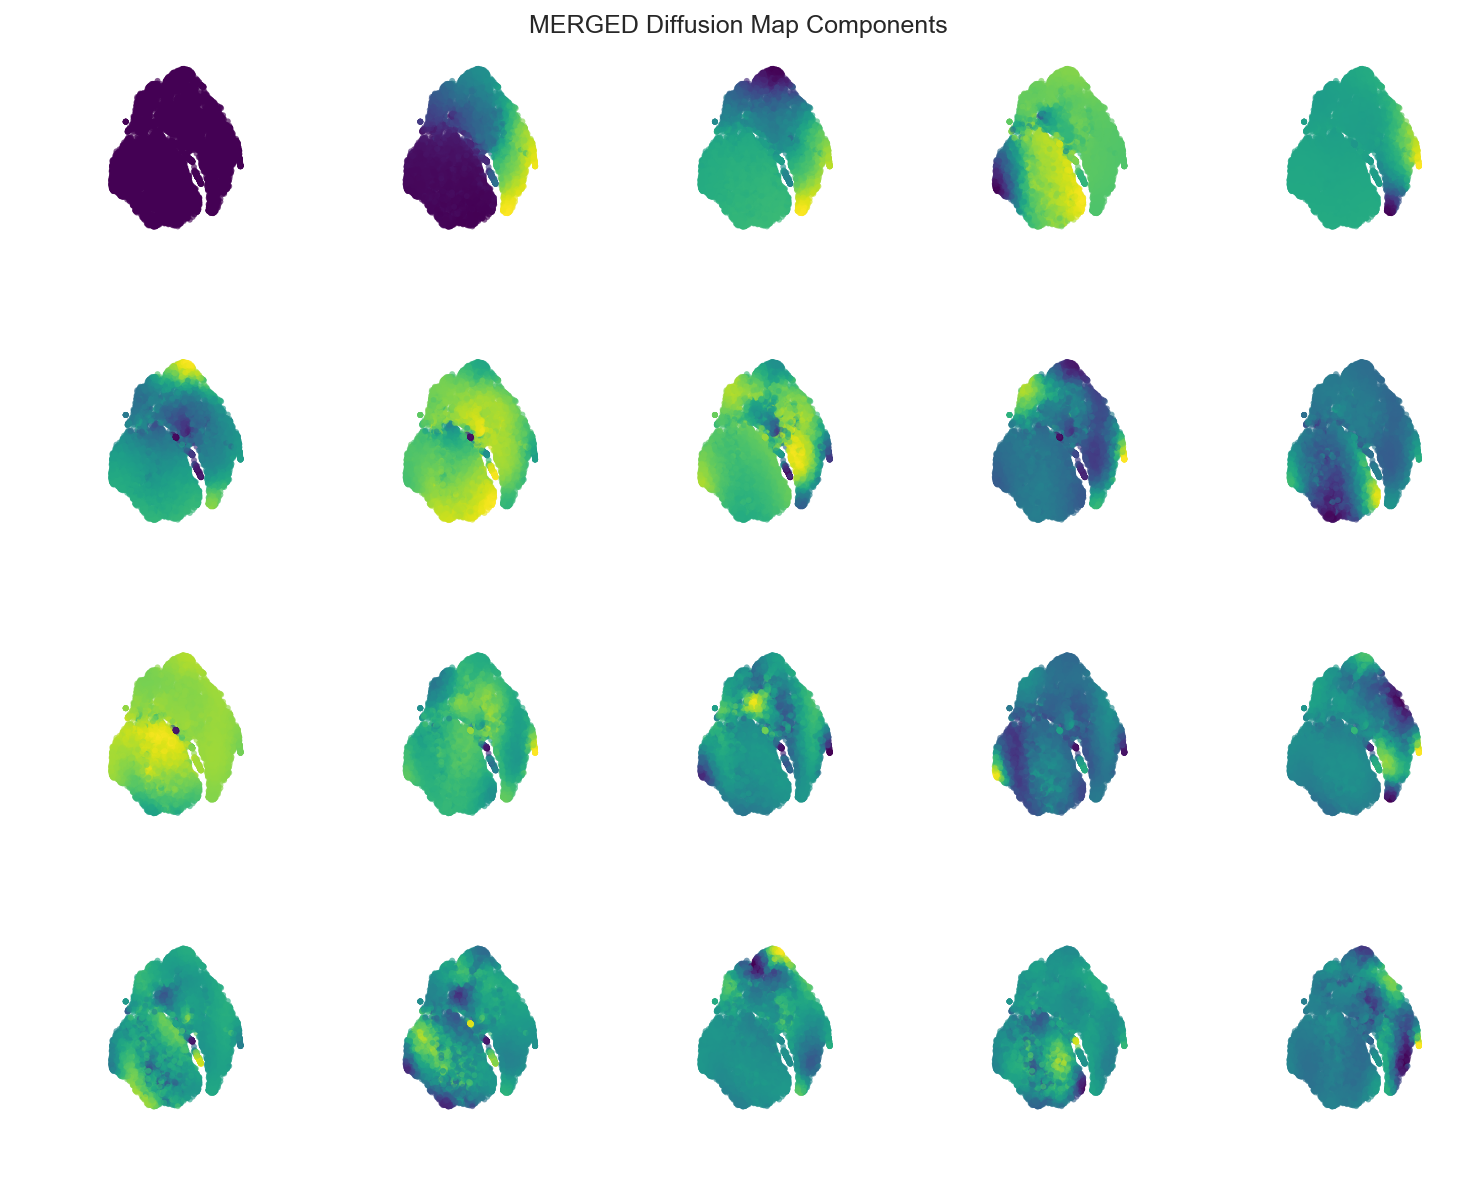

In [28]:
# visualize diffusion components
f, axes = experiment.plot_diffusion_components()
f.suptitle('{} Diffusion Map Components'.format(SAMPLE_NAME), fontsize=12)
f.tight_layout()
f.savefig(FIGURE_DIR + SAMPLE_NAME + '_diffusion_components.png', dpi=200)

In [29]:
# select diffusion components that appear to be capturing spatial information. Omit #0
USE_COMPONENTS = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19])

In [30]:
# get gene correlations with each component
experiment.run_diffusion_map_correlations(components=USE_COMPONENTS)

/Users/ambrose/PycharmProjects/SEQC/src/seqc/core.py:1282: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  x = pd.rolling_mean(component_data[order], no_cells)[no_cells:]
/Users/ambrose/PycharmProjects/SEQC/src/seqc/core.py:1286: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  vals = pd.rolling_mean(self.molecules.values[order, :], no_cells, axis=0)[no_cells:]


Some notes:

1. Component 3 is of interest, negative enrichments will reveal GO categories that T-cells in BO are enriched for. 
2. Similarly, Component 1 is of interest, as those are primarily CL myeloid cells
3. Component 5 is highly loaded with myeloid cells that are expressed in all 4 tumor populations

In [31]:
# run GO-biological process
output_stem = DATA_DIR + 'gsea/gsea_gobp_{k}'.format(k=SAMPLE_NAME)
os.makedirs(DATA_DIR + 'gsea', exist_ok=True)
errors = experiment.run_gsea(output_stem=output_stem,
                             gmt_file=(ORGANISM, 'gofat.bp.v1.0.gmt.txt'),
                             components=USE_COMPONENTS)
for e in errors:
    if e:
        print(e)

initializing 7 worker processes and mapping GSEA to them.


In [35]:
# print annotations
experiment.select_biological_components(output_stem, n=10, alpha=0.1, components=USE_COMPONENTS)

component: 1
negative enrichment:
['GO_0006397|MRNA PROCESSING', 'GO_0008380|RNA SPLICING', 'GO_0016071|MRNA METABOLIC PROCESS', 'GO_0000377|RNA SPLICING, VIA TRANSESTERIFICATION REACTIONS WITH BULGED ADENOSINE AS NUCLEOPHILE', 'GO_0006396|RNA PROCESSING', 'GO_0000398|NUCLEAR MRNA SPLICING, VIA SPLICEOSOME', 'GO_0000375|RNA SPLICING, VIA TRANSESTERIFICATION REACTIONS', 'GO_0051276|CHROMOSOME ORGANIZATION', 'GO_0006325|CHROMATIN ORGANIZATION', 'GO_0016568|CHROMATIN MODIFICATION']
positive enrichment:
['GO_0009611|RESPONSE TO WOUNDING', 'GO_0006897|ENDOCYTOSIS', 'GO_0010324|MEMBRANE INVAGINATION', 'GO_0016042|LIPID CATABOLIC PROCESS', 'GO_0016044|MEMBRANE ORGANIZATION', 'GO_0006954|INFLAMMATORY RESPONSE', 'GO_0000041|TRANSITION METAL ION TRANSPORT', 'GO_0042060|WOUND HEALING', 'GO_0016052|CARBOHYDRATE CATABOLIC PROCESS', 'GO_0002526|ACUTE INFLAMMATORY RESPONSE']

component: 2
negative enrichment:
['GO_0016064|IMMUNOGLOBULIN MEDIATED IMMUNE RESPONSE', 'GO_0045087|INNATE IMMUNE RESPONSE', 

In [36]:
# select biologically relevant components; to do this go to DATA_DIR and look at the 
# index.html documents for each component. If the enrichment is relevant to your experiment,
# keep it and use it!
   
BIOLOGICAL_COMPONENTS = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18, 19])
subset = experiment.select_genes_from_diffusion_components(BIOLOGICAL_COMPONENTS, plot=False)

## ANALYZE DATA, GENE SELECTION COMPLETED

In [37]:
## re-run PCA 
subset.run_pca()

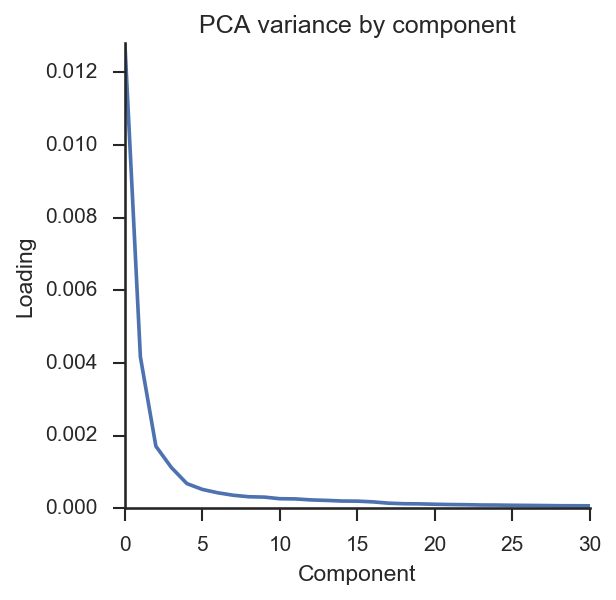

In [38]:
fig, ax = plt.subplots(figsize=(4, 4))
experiment.plot_pca_variance_explained(fig=fig, ax=ax)
fig.savefig(FIGURE_DIR + SAMPLE_NAME + '_pca_variance_explained_r2.png', dpi=200)

In [39]:
# re-select number of components based on elbow
N_COMPONENTS = 8

In [40]:
# re-run tSNE
subset.run_tsne(n_components=N_COMPONENTS)

/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:373: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


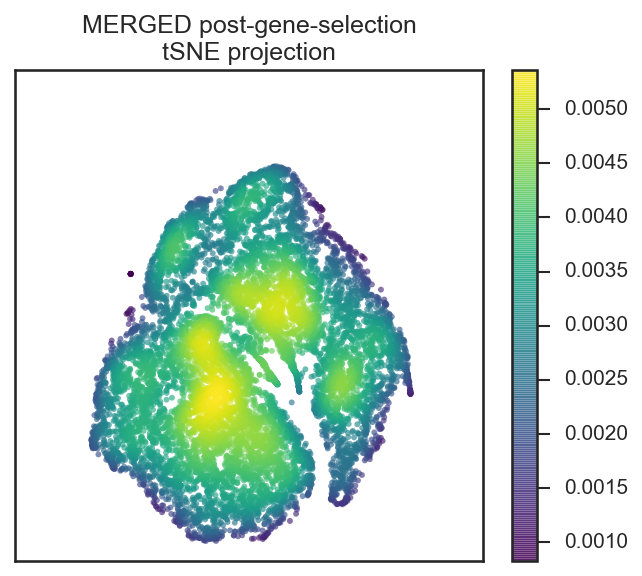

In [41]:
# plot tsne, second round
f, ax = plt.subplots(figsize=(4.5, 4))
f, ax = subset.plot_tsne(title='{} post-gene-selection\ntSNE projection'.format(SAMPLE_NAME))
f.tight_layout()
plt.savefig(FIGURE_DIR + SAMPLE_NAME + '_post_gene_selection_tsne.png', dpi=200)

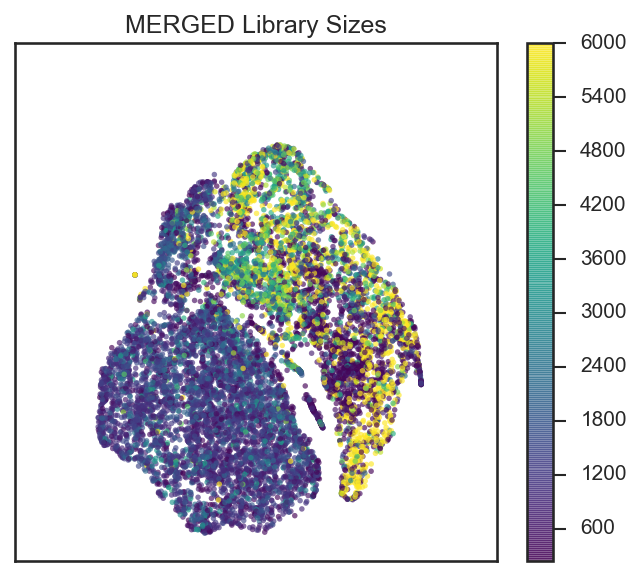

In [42]:
# plot library sizes
VMAX = 6000  # lower this if the plot's color spectrum isn't informative. 
fig, ax = plt.subplots(figsize=(4.5, 4))
fig, ax = experiment.plot_tsne_by_cell_sizes(fig=fig, ax=ax, sizes=library_sizes.values,
                                             title='{} Library Sizes'.format(SAMPLE_NAME),
                                             vmax=VMAX)
fig.tight_layout()
fig.savefig(FIGURE_DIR + SAMPLE_NAME + '_library_size_tsne.png', dpi=200)

In [44]:
# run phenograph
N_NEIGHBORS = 80  # higher numbers == lower cluster numbers
subset.run_phenograph(n_pca_components=N_COMPONENTS, k=N_NEIGHBORS)

Finding 80 nearest neighbors using minkowski metric and 'kd_tree' algorithm


/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:373: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


Neighbors computed in 0.4305419921875 seconds
Jaccard graph constructed in 5.065721035003662 seconds
Wrote graph to binary file in 2.29042911529541 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.810067
Louvain completed 21 runs in 8.943985939025879 seconds
PhenoGraph complete in 16.863502979278564 seconds


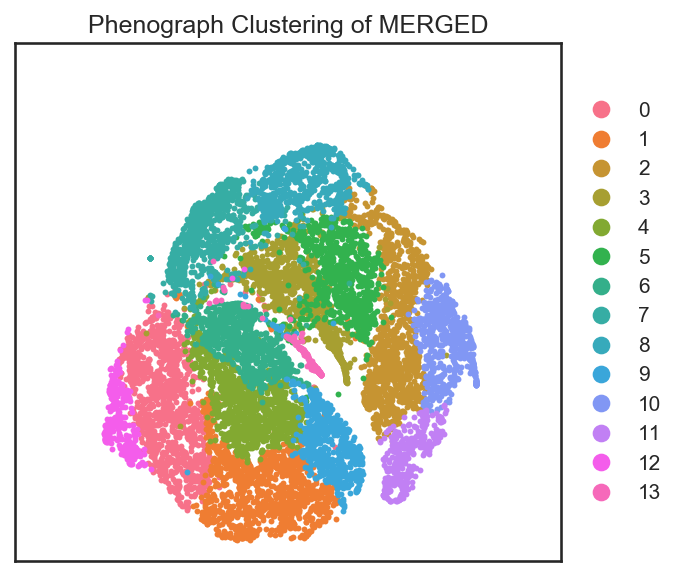

In [45]:
fig, ax = plt.subplots(figsize=(4, 4))
subset.plot_phenograph(fig=fig, ax=ax)
ax.set_title('Phenograph Clustering of {}'.format(SAMPLE_NAME))
fig.tight_layout()
plt.savefig(FIGURE_DIR + SAMPLE_NAME + '_phenograph_projection.png', dpi=200,
            bbox_extra_artists=(ax.get_legend(),), bbox_inches='tight')

In [ ]:
from numpy import ma as ma
ma.mask_equal(subset.molecules.values, 0)

In [ ]:
# get differential expression
global_diffexpr = subset.differential_expression(alpha=0.01)

In [ ]:
global_diffexpr

In [ ]:
# get genes annotating each component
marker_genes = subset.annotate_clusters_by_expression(alpha=0.05)

In [ ]:
# write marker genes to file
markers = {}
for i, series in marker_genes.iterrows():
    markers[str(i)] = list(series.ix[series.values].index)
with open(DATA_DIR + '{}_cluster_marker_genes.json'.format(SAMPLE_NAME), 'w') as f:
    f.write(json.dumps(markers, separators=(',', ': '), indent=4))

In [ ]:
# todo multiprocess this. Could be much faster.
# get pairwise differential expression between each population, use the rank-ordered genes
# to do GSEA enrichment analyses
clusters = set(subset.cluster_assignments)
pairs = combinations(clusters, 2)
for a, b in pairs:
    a_data = subset.molecules.index[subset.cluster_assignments == a]
    b_data = subset.molecules.index[subset.cluster_assignments == b]
    p, fc = subset.pairwise_differential_expression(a_data, b_data)
    fc = fc.fillna(1)
    fc[np.isinf(fc)] = 1
    
    # plot fold changes of individually differentially expressed genes
    high_expr = p[(fc > 1) & (p < 0.05)].sort_values().index[:100]
    low_expr = p[(fc < 1) & (p < 0.05)].sort_values().index[:100]
    f, ax = subset.plot_gene_expression(high_expr)
    try:
        f.savefig(FIGURE_DIR + SAMPLE_NAME + '_{!s}high_{!s}low.png'.format(b, a))
    except SystemError:
        pass
    plt.close()
    f, ax = subset.plot_gene_expression(low_expr)
    try:
        f.savefig(FIGURE_DIR + SAMPLE_NAME + '_{!s}high_{!s}low.png'.format(a, b))
    except SystemError:
        pass
    plt.close()
    
    # run GSEA for BP and TF motifs.
    ranked_genes = fc.sort_values(inplace=False, ascending=False)
    pd.DataFrame(ranked_genes).fillna(0).to_csv(
        DATA_DIR + SAMPLE_NAME + '_{!s}v{!s}.rnk'.format(a, b), sep='\t', header=False)
    seqc.core.Experiment.run_gsea_preranked_list(
        DATA_DIR + SAMPLE_NAME + '_{!s}v{!s}.rnk'.format(a, b),
        DATA_DIR + SAMPLE_NAME + '_gobp_{!s}v{!s}'.format(a, b),
        gmt_file=(ORGANISM, 'gofat.bp.v1.0.gmt.txt'))
    seqc.core.Experiment.run_gsea_preranked_list(
        DATA_DIR + SAMPLE_NAME + '_{!s}v{!s}.rnk'.format(a, b),
        DATA_DIR + SAMPLE_NAME + '_tf_{!s}v{!s}'.format(a, b),
        gmt_file=(ORGANISM, 'c3.all.v5.0.symbols.gmt.txt'))
    print('Done processing {} vs. {}'.format(a, b))

In [ ]:
subset.save(DATA_DIR + SAMPLE_NAME + '_processed.p')